# the phase kickback trick

### Introduction

This is going to be a very short lecture, but still relevant to get familiar with one of the most simple and common tricks used in quantum computing: the phase kickback.

Before introducing and implementing an example of phase kickback, we should also introduce some terminology.
We typically refer to the main qubits of a system as the **input register** of that system.

In some situations, we could also need some more qubits, which we call **ancillas**. The **ancilla** is typically an extra qubit of your system, which can be useful for many reasons.

In a nutshell, the phase kickback is a process in which we apply a controlled operation on a target qubit using another qubit as control, but amazingly we get a modification only in the control qubit!

Let's start importing some useful objects.

#### A necessary premise

What we are going to see is one interesting way to apply an amplitude manipulation of the **input register** without actually apply any gate on it!

It is important to mention that this same effect could be obtained by directly applying some gate on the **input register**, but this example is still interesting and, moreover, it will be useful to understand more complex algorithms such as Grover.

### Phase kickback

Let's consider two qubits: a first one is used as control, while a second is the target. An important requirement to exploit the phase kickback is that the second qubit's state is an eigenvector of the operator we aim to apply.

#### Phase kickback implementation

1. we initialize a two qubit circuit;
2. we apply an Hadamard gate to the first qubit, which is the **input register**, which will be the control one, and a Pauli X to the second qubit. This step will prepare the system into the state $$ |\psi_1\rangle = \frac{|01\rangle + |11\rangle}{\sqrt{2}}; $$
3. if the state vector of the target qubit $|q_{\rm t}\rangle$ is an eigenvector of the chosen gate $G$, it satisfies $$ G|q_{\rm t}\rangle = \lambda_G\,|q_{\rm t}\rangle.$$
4. In our case we may consider the controlled version of a $G$ gate, which has $|1\rangle$ as eigenvector:  $$ |\psi_2\rangle = CG |\psi_1\rangle = \frac{|01\rangle + G|11\rangle}{\sqrt{2}} =
\frac{|01\rangle + \lambda_{G}|11\rangle}{\sqrt{2}} = \frac{|0\rangle + \lambda_{G}|1\rangle}{\sqrt{2}} \times |1\rangle.$$

After step 4., the state of the control qubit has been changed, while the target one is untouched.

#### Implementation

In [ ]:
# Installation process for needed libraries
!pip install qibo
!pip install qibojit
!pip install git+https://github.com/qiboteam/qiboedu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.2/258.2 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.0/524.0 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Cloning https://github.com/qiboteam/qiboedu to /tmp/pip-req-build-7h6w29sl
  Running command git clone --filter=blob:none --quiet https://github.com/qiboteam/qiboedu /tmp/pip-req-build-7h6w29sl
  Resolved https://github.com/qiboteam/qiboedu to commit 5de265148000f4e13217a16b535d14ca0b7e3d4a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━

In [ ]:
import qibo
from qibo import Circuit, gates

from qiboedu.scripts.plotscripts import plot_probabilities_from_state

In [ ]:
# setting the backend
qibo.set_backend("numpy")

[Qibo 0.2.7|INFO|2024-04-09 23:47:44]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0


In [ ]:
# circuit preparation: hadamard and NOT gate on the ancilla
c = Circuit(2)
c.add(gates.H(0))
c.add(gates.X(1))

# checking the circuit state
print(c())

(0.70711+0j)|01> + (0.70711+0j)|11>


We consider the $T$ gate, which has the state $|1\rangle$ as eigenvector with eigenvalue $\lambda_G \neq 0$.

In [ ]:
# check T has |1> as eigenvec
c = Circuit(1)
c.add(gates.X(0))
c.add(gates.T(0))

print(c())

(0.70711+0.70711j)|1>


In [ ]:
# write an execute_circuit function with the possibility of adding and removing the kickback procedure
def execute_circuit(kickback=True):
  """ Execute circuit with or without the phase kickback """
  c = Circuit(2)
  c.add(gates.H(0))
  c.add(gates.X(1))
  if kickback:
    c.add(gates.T(1).controlled_by(0))
  c.add(gates.H(0))
  c.add(gates.M(*range(2)))

  outcome = c(nshots=1000)
  return outcome

(1+0j)|01>


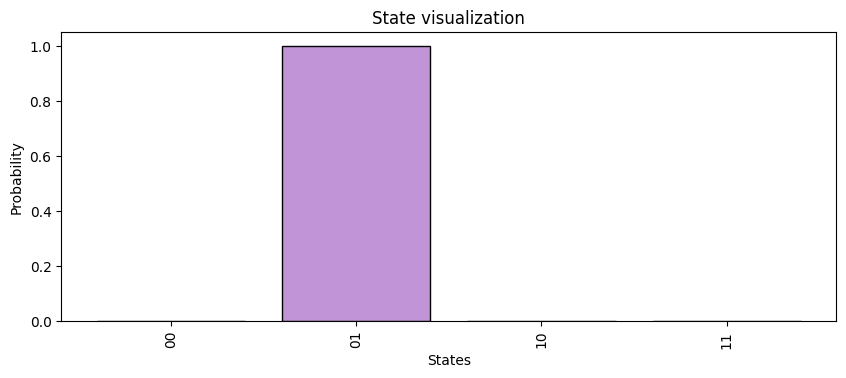

In [ ]:
# collect outcome with kickback false
outcome = execute_circuit(kickback=False)

print(outcome)

# plotting the probabilities
plot_probabilities_from_state(outcome.state())

(0.85355+0.35355j)|01> + (0.14645-0.35355j)|11>


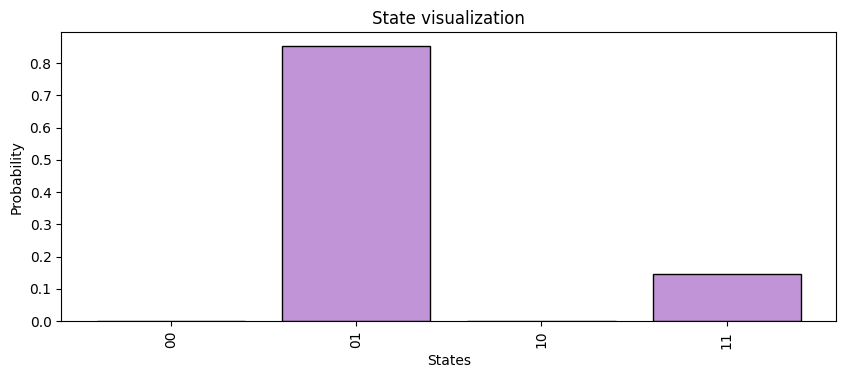

In [ ]:
# collect outcome with kickback false
outcome = execute_circuit()

print(outcome)

plot_probabilities_from_state(outcome.state())

Exercise: can you find a quantum gate $CG$ which applies a larger kickback effect then the $CT$ ? In other words, can you replace $CT$ in the previous circuit with a gate which reduces the $|01\rangle$ amplitude increasing the one of $|11\rangle$ ?

#### What happens if we repeat the phase kickback many times?

We now add the possibility to repeat the circuit architecture many times, in order to see what happens if we recursively manipulate the amplitude of the input register.

In [ ]:
# adding recursion using the 'ntimes' argument to the execute_circuit function
def execute_circuit(kickback=False, ntimes=1):
  """ Repeat phase kickback ntimes. """
  c = Circuit(2)
  c.add(gates.X(1))

  for i in range(ntimes):
    c.add(gates.H(0))
    if kickback:
      c.add(gates.T(1).controlled_by(0))
    c.add(gates.H(0))

  c.add(gates.M(*range(2)))

  outcome = c(nshots=1000)
  return outcome

(1-0j)|11>


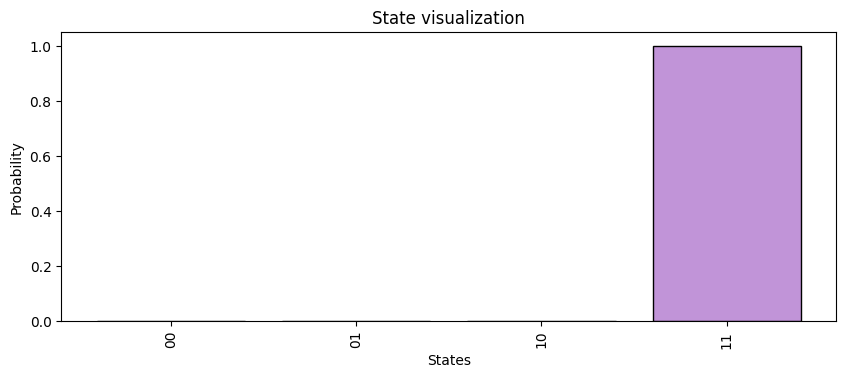

In [ ]:
# collect the outcome with kickback true and niter
outcome = execute_circuit(kickback=True, ntimes=4)

print(outcome)

plot_probabilities_from_state(outcome.state())

# Grover search algorithm

## Introduction

The Grover algorithm is probably one of the most famous quantum computing proof of utility.

It has been known as "Grover search algorithm" because it is effective in a context in which we aim to find a specific solution of a problem among a set of possible solutions.

#### Problem setup

In this notebook, we are going to implement the Grover algorithm using a system of $N$ qubits in order to explore a set of $M=2^N$ possible solutions and, without going deep into the mathematical details, we will proof we need a number of Grover iterations proportional to $\sqrt{M}$ to find the target solution with probability close to one.

---

To give the lesson a more concrete aspect, let's take a more realistic problem:
Suppose you're at a party with $M=2^N$ friends. While you're peacefully drinking your coffee, you get distracted for a moment, and someone, without you noticing, pours sugar into your coffee.

It's a disaster because you like your coffee bitter! So, you absolutely need to find the person responsible for this.

Let's also suppose that there is no concrete evidence that can lead us to the guilty person, however, while poursing coffee inside your mug, the thief left a hair inside the cup, which can be used to extract DNA.

Perfect! we can compare the guilty DNA with that of every person who was at the party at that moment.

---

This problem can be **classically** tackled by checking all the people one by one and, in the worst case, it takes $M = 2^N$ attempts before finding the guilty person in the group. On the other hand, using quantum computing and the Grover algorithm, we will see the solution can be found with a number of algorithm's calls that scales as $\sqrt{M}$: *we gain a quadratic speedup!*

Let's start investigating the culprit by importing some packages.

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from qiboedu.scripts import utils, plotscripts

qibo.set_backend("numpy")
print(qibo.get_backend())

[Qibo 0.2.7|INFO|2024-04-09 23:48:51]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0


numpy


Secondly, we need to generate a set of elements which can deal with a quantum computer and are able to represent all the possible solutions we want to explore. In practice, we create a set of $2^N$ bitstrings and we associate every person at the party to one of the bistrings.

We use the function `scripts.utils.generate_bitstring_combination` to generate a list containing all the possible bitstrings of zeros and ones composed of $N$ bits.

In [ ]:
# set the problem dimensionality --> the size of the set to be explored
n=5
nshots=1000000

# generating the bitstrings list
bitstrings = utils.generate_bitstring_combinations(n)

print(bitstrings)

['00000', '00001', '00010', '00011', '00100', '00101', '00110', '00111', '01000', '01001', '01010', '01011', '01100', '01101', '01110', '01111', '10000', '10001', '10010', '10011', '10100', '10101', '10110', '10111', '11000', '11001', '11010', '11011', '11100', '11101', '11110', '11111']


In [ ]:
# check whether the length of the list is equal to 2**n
print(2**n)
print(len(bitstrings))

32
32


Let's generate the list of people who were at the party.

In [ ]:
!pip install Faker
from faker import Faker

fake = Faker()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.1 MB/s eta 0:00:00


In [ ]:
# generate 2**n fake names with faker.name()
names = []
for i in range(2**n):
  names.append(fake.name())

print(names)

['Alison Vargas', 'Crystal Terry', 'Christina Arnold', 'Darin Ayers', 'John Martin', 'Pamela Pollard', 'Chloe Jimenez', 'Yvonne Mccoy', 'Zachary Lane', 'John Davis', 'Mark Ferrell', 'Harold Rose', 'Christina Mathews', 'Jessica Fisher', 'Angel Stephenson', 'Tommy Woods', 'Katie Underwood', 'Amy Owens', 'Jessica Thomas', 'Keith Fox', 'Juan Smith', 'Amanda Collier', 'John Chen', 'Scott Ford', 'Christine Herrera', 'Cindy Phillips', 'Paul Hines', 'Michelle Hill', 'Bianca Case', 'Kevin Obrien', 'Deborah Marks', 'Kari Meyer']


In practice, we have now a list of strings, in which the element of index $k$ represents the $k$-th suspect among the people.

Let's assume the guilty guy in the list is the number 11!

In [ ]:
guilty_index = 11

print(f"Guilty index: {guilty_index}")
print(f"Guilty {names[guilty_index]} corresponding to state {bitstrings[guilty_index]}")

Guilty index: 11
Guilty Harold Rose corresponding to state 01011


### Grover algorithm main ingredients

Now the problem is set up and we can focus on the Grover implementation.

We need to follow some steps:

1. we prepare a system of $N+1$ qubits into the $|0\rangle^{\otimes N} |1\rangle$ state. The ancilla gate is the one prepared as usual into $|1\rangle$;
2. we apply Hadamard gates to all the qubits in order to create superposition of all the $2^N$ states of the input register. We call this superposed state $|s\rangle$;
3. we apply an **oracle** function $U_f$ to the qubits, which is constructed in order to detect the guilty state among the others. In our narrative, it can be seen as the machine which process the DNA of the people, allowing to find the guilty person. In a quantum computer notation, it is a set of operation which flips the sign of the amplitude of the state corresponding to the guilty guy (the number 11 in our case).
4. we apply the **diffusion operator** $U_s = 2|s\rangle \langle s| - I$, whose effect consists in reflecting the amplitudes of the system about the average amplitude. In practice, acting together with the oracle over the superposed states, it increases the amplitude of the guilty state and decrease the one of the others.
5. we repeat the process a number of time proportional to $\sqrt{M}$ to find the guilty guy state with probability close to one.

We see some more detail in the following cells. For now, we can start implementing all the elements of the Grover algorithm.

#### Initial and final layers of the circuit

Regardless of the number of times we repeat the application of $U_f$ and $U_s$, we need to build the initial and the final circuit layer.

In [ ]:
# The Grover circuit will be composed of many layers
# the first and the last layer are always the same and we call the initial_layer and final_layer

# function to set the circuit and initial superposition
def build_initial_layer(n):
  """ Build the initial superposition in Grover circuit """
  # n + 1
  c = Circuit(n+1)
  # state preparation into |0>...|1>
  c.add(gates.X(n))
  for q in range(n+1):
    c.add(gates.H(q))

  return c

# function to build a circuit containing the final measurements
def build_final_layer(n):
  c = Circuit(n+1)
  c.add(gates.M(*range(n)))
  return c

Let's visualize the initial and final layer.

In [ ]:
# build the circuit combining the initial and final layers
c = build_initial_layer(n) + build_final_layer(n)

print(c.draw())

q0: ─H───M─
q1: ─H───M─
q2: ─H───M─
q3: ─H───M─
q4: ─H───M─
q5: ─X─H───


With this setup, the final state is the equally superposed state and we expect uniformly distributed probabilities between all the available states.
To visualize it, we can use the `scripts.plotscripts.plot_grover_probabilities` function, which shows the probability of each state calculated using the collected frequencies after executing the circuit `nshots` times.

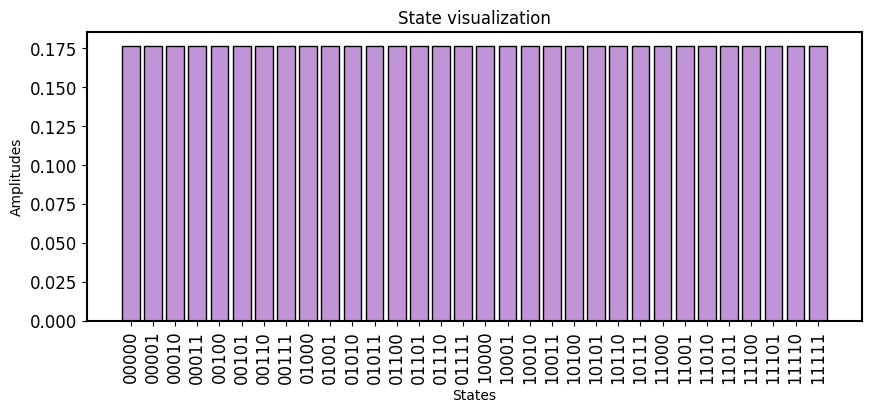

In [ ]:
# use plot_input_register_amplitudes passing the quantum state
plotscripts.plot_input_register_amplitudes(c().state())

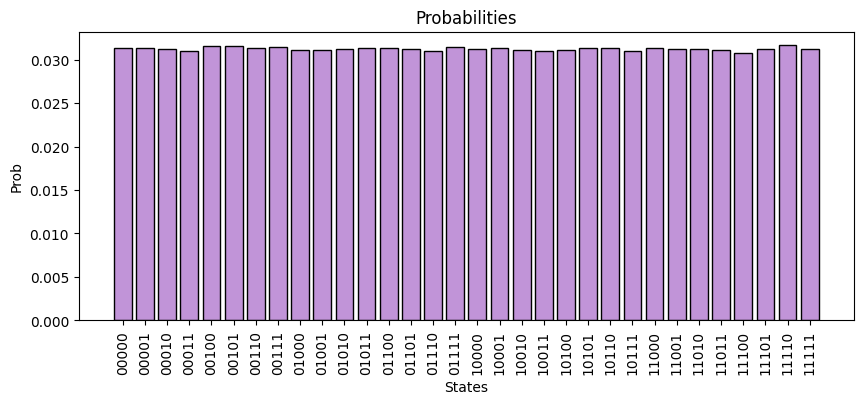

In [ ]:
# use plot_grover_probabilities which requires the circuit and nshots
# here we are using the frequencies, and the result is no more exact
plotscripts.plot_grover_probabilities(c, nshots)

As we can see from the plot, the state is prepared into $|s\rangle$.

#### Oracle

We need now to construct the oracle $U_f$. This can be done firstly building a function:

$$ f: \{0,1\}^n \to \{0,1\} $$

which returns $1$ in the only case in which the input variable $x$ is the one we are searching for, otherwise it returns $0$. Given this, the oracle $U_f$ acts on the $N$-qubits state $|x\rangle$ in the following way: $$ U_f |x\rangle = (-1)^{f(x)}|x\rangle, $$

flipping the amplitude of the state only if $|x\rangle$ is the guilty one:

$$
\begin{cases}
U_f\,|x\rangle = - |x\rangle \qquad \text{if} \quad |x\rangle \quad \text{guilty}, \\
U_f\,|x\rangle = + |x\rangle \qquad \text{if} \quad |x\rangle \quad \text{innocent}. \\
\end{cases}
$$

The easiest way to implement such an operator consists in building a multi-controlled gate which is "triggered" by the guilty state only. It means we need to define a gate which acts on the ancilla and, with its action, it provokes a phase kickback effect on the guilty state only.

Since the multi-controlled gate is typically activated by the component $|1\rangle^{\otimes N}$ of the input register state, if the guilty state is the $|1\rangle^{\otimes N}$ itself, our job gets easier: in fact, the multi-controlled gate will already do the job we want to do.

Otherwise, if the guilty state is something different from $|1\rangle^{\otimes N}$, we just need to manipulate the input register state so that the component which activates the gate is the guilty one instead. A simple way of doing this is apply a NOT gate to each qubit of the system which, in the bitstring, corresponds to a zero.

In [ ]:
# define a function which implements the oracle given quilty_index:
def build_oracle(guilty_index, n):
  bitstring = bitstrings[guilty_index]
  circuit = Circuit(n+1)
  zeros = []
  for i, bit in enumerate(bitstring):
    if bit == "0":
      zeros.append(i)
  [ circuit.add(gates.X(q)) for q in zeros ]
  circuit.add(gates.X(q=n).controlled_by(*range(n)))
  [ circuit.add(gates.X(q)) for q in zeros ]

  return circuit

Let's have a look to the circuit.

In [ ]:
# build the oracle circuit and draw it
c = build_oracle(guilty_index, n)
print(c.draw())

q0: ─X─o─X─
q1: ───o───
q2: ─X─o─X─
q3: ───o───
q4: ───o───
q5: ───X───


Execute the whole circuit involving the oracle.

In [ ]:
# combining all the layers of the circuit
c = build_initial_layer(n) + build_oracle(guilty_index, n) + build_final_layer(n)

print(c.draw())

q0: ─H─X─o─X─M─
q1: ─H───o───M─
q2: ─H─X─o─X─M─
q3: ─H───o───M─
q4: ─H───o───M─
q5: ─X─H─X─────


We can visualize the amplitudes of the input register using the function `scripts.plotscripts.plot_input_register_amplitudes`.

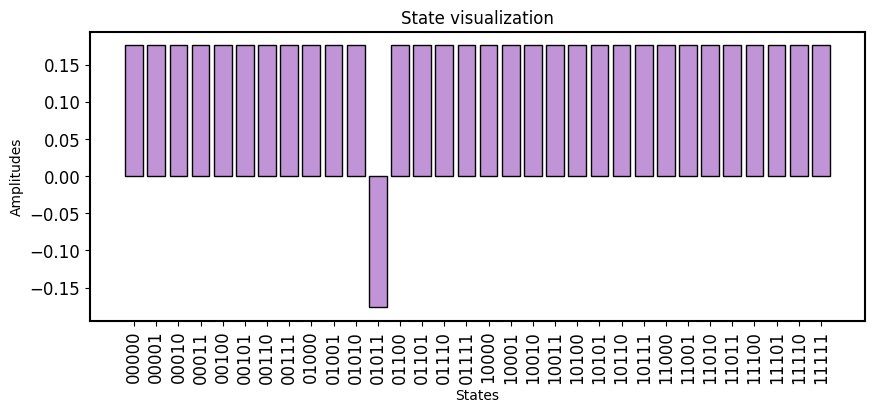

In [ ]:
# plot the input register amplitudes using plot_input_register_amplitudes
plotscripts.plot_input_register_amplitudes(c().state())

Even though the amplitude of the guilty state is flipped, if we look to the probabilies associated to the states of the input register we still collect an equally superposed state.

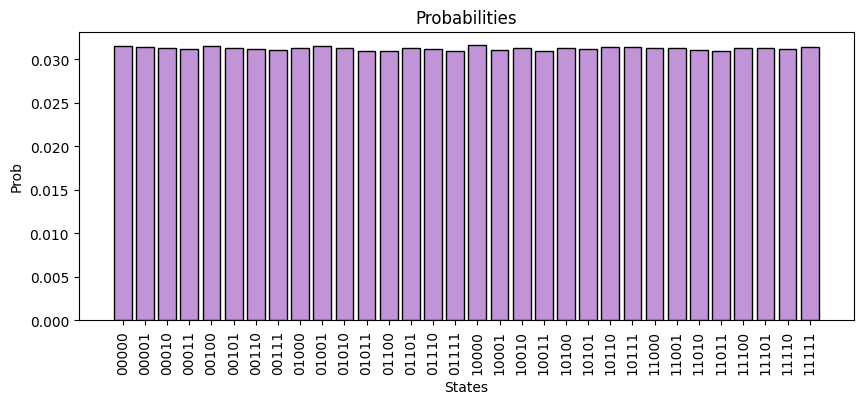

In [ ]:
# plot the probabilities associated to this state using the plot_grover_probabilities function
# it requires the circuit and nshots as arguments
plotscripts.plot_grover_probabilities(c, nshots)

#### The diffusion operator

The next step in Grover is to implement the diffusion operator, whose effect is to amplify the guilty amplitude while decreasing the others.
Typically it is implemented using a multi-controlled Z gate acting on the ancilla e controlled by the input register. This multi-controlled Z has to be preceded and followed by a layer of Hadamards applied to the imput register. For now, we'll ask you to accept this statement as it is. In the notebook corresponding to the Lecture 5 we delve deeper in the details of this implementation.

One way to practically implement the CZ consists in applying an X gate to all the qubits of the input register, then apply a multi-controlled NOT gate on the ancilla and controlled by the whole input register. Finally, we have to re-apply the X gates to the input register.

In [ ]:
# implement the diffusion operator
def build_diffusion_operator(n):
  c = Circuit(n+1)
  c.add(gates.X(n))
  for q in range(n):
    c.add(gates.H(q))
    c.add(gates.X(q))

  c.add(gates.X(q=n).controlled_by(*range(n)))
  for q in range(n):
    c.add(gates.X(q))
    c.add(gates.H(q))

  return c

In [ ]:
# function to apply nsteps of Grover
def build_grover(n, nsteps):
  c = Circuit(n+1)
  # pply the initial layer
  c += build_initial_layer(n)

  for _ in range(nsteps):
    c += build_oracle(guilty_index, n)
    c += build_diffusion_operator(n)

  c += build_final_layer(n)

  return c


In [ ]:
# build with 1 step
c = build_grover(n, 1)

print(c.draw())

q0: ─H─X─o─X─H─X─o─X─H─M─
q1: ─H───o─H─X───o─X─H─M─
q2: ─H─X─o─X─H─X─o─X─H─M─
q3: ─H───o─H─X───o─X─H─M─
q4: ─H───o─H─X───o─X─H─M─
q5: ─X─H─X─X─────X───────


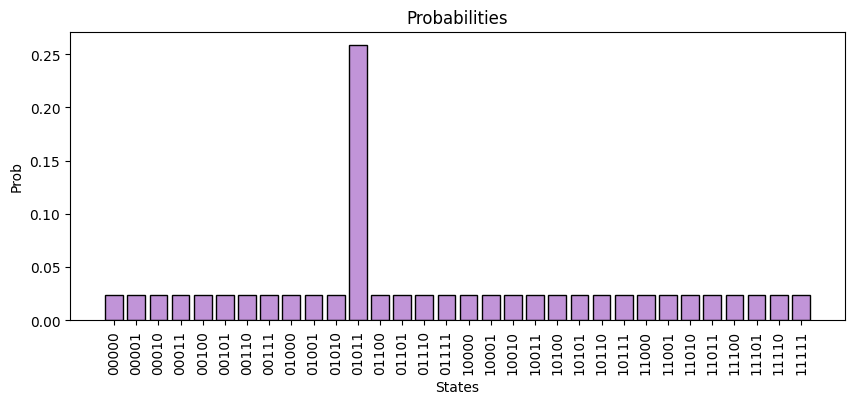

In [ ]:
# plot_grover_probabilities, passing grover circuit and nshots
plotscripts.plot_grover_probabilities(c, nshots)

In [ ]:
# build with 2 step
c = build_grover(n, 2)

print(c.draw())

q0: ─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─M─
q1: ─H───o─H─X───o─X─H───o─H─X───o─X─H─M─
q2: ─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─M─
q3: ─H───o─H─X───o─X─H───o─H─X───o─X─H─M─
q4: ─H───o─H─X───o─X─H───o─H─X───o─X─H─M─
q5: ─X─H─X─X─────X───────X─X─────X───────


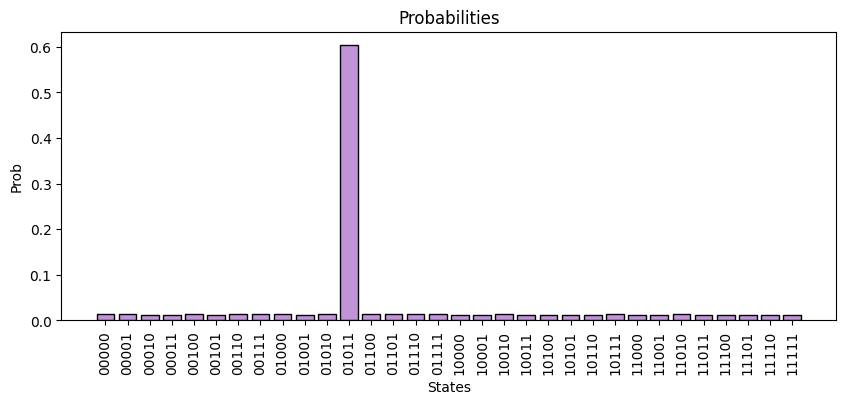

In [ ]:
# plot_grover_probabilities, passing grover circuit and nshots
plotscripts.plot_grover_probabilities(c, nshots)

From the plot and the amplitudes of the final state it is clearer and clearer who is the guilty person!
In the following cell we check explicitly who is the guilty person.

In [ ]:
# collecting the frequencies with the current circuit
frequencies = c(nshots=1000).frequencies()

# writing the corresponding probabilities dividing by nshots
probabilities = []
for bitstring in frequencies:
  probabilities.append(frequencies[bitstring] /1000)

index = np.argmax(probabilities)
print(index)

11


We expect the optimal number of Grover steps is $\sim\pi/4 \sqrt{M}$ from the theoretical results.
Let's check what happens with a growing number of steps.

In [ ]:
# computing the optimal number if iterations
opt = (np.pi / 4) * np.sqrt(2**n)
print(opt)

4.442882938158366


In [ ]:
# empty max probabilities list
prob_target = []

# number of experiments
N = 10

for i in range(N):
  c = build_grover(n, i)
  prob_target.append(utils.compute_max_probability(c, nshots))

Plot the sequence of registered probabilities.

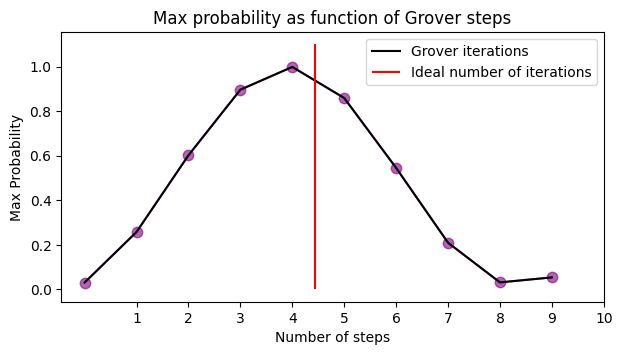

In [ ]:
plt.figure(figsize=(7, 7*4/8))
plt.plot(np.arange(0, N, 1), prob_target, ls="-", marker=".", markersize=15, alpha=0.6, color="purple")
plt.plot(np.arange(0, N, 1), prob_target, ls="-", color="black", label="Grover iterations")
plt.vlines(opt, 0, 1.1, color="red", label="Ideal number of iterations")
plt.xticks(np.arange(1, N+1))
plt.title("Max probability as function of Grover steps")
plt.xlabel("Number of steps")
plt.ylabel("Max Probability")
plt.legend()
plt.show()

In [ ]:
# build with optimal number of step
c = build_grover(n, 4)

print(c.draw())

q0: ─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─M─
q1: ─H───o─H─X───o─X─H───o─H─X───o─X─H───o─H─X───o─X─H───o─H─X───o─X─H─M─
q2: ─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─M─
q3: ─H───o─H─X───o─X─H───o─H─X───o─X─H───o─H─X───o─X─H───o─H─X───o─X─H─M─
q4: ─H───o─H─X───o─X─H───o─H─X───o─X─H───o─H─X───o─X─H───o─H─X───o─X─H─M─
q5: ─X─H─X─X─────X───────X─X─────X───────X─X─────X───────X─X─────X───────


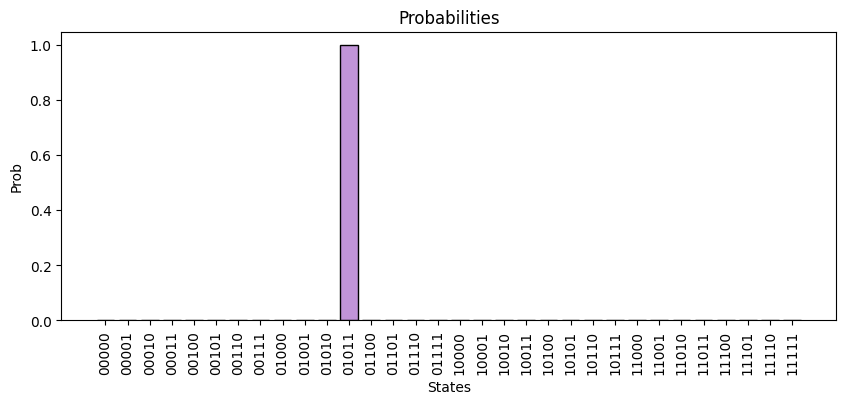

In [ ]:
plotscripts.plot_grover_probabilities(c, nshots)